In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import glob
import math

In [2]:
## Set this to the root path of the directory of this script (empty if already in root path)
root_path = ''

In [3]:
# To load in 2021 data:'
# path = root_path + '/Part_B_National_Reports_2021'

#To load in 2019 data:
path = root_path + '/Part_B_National_Reports_2019'

#### Read in Data Files

In [4]:
# Read in spending data
excel_files = glob.glob(os.path.join(path, "*.xlsx"))

frames = []
# loop over the list of csv files
for f in excel_files:
    # read the csv file
    df = pd.read_excel(f)

    # Sets columns to the fourth row in the dataframe (first few rows are filled with other text)
    df.columns = df.iloc[3]

    # Gets rid of unncessary rows
    df = df[4:-1]

    # Filters to only include rows that say "total"
    df = df[df['MODIFIER'] == 'TOTAL']

    # Takes only the columns we need
    df = df[['HCPCS', 'ALLOWED SERVICES', 'ALLOWED CHARGES', 'PAYMENT']]

    frames.append(df)

new_data = pd.concat(frames)
new_data.rename(columns = {'HCPCS' : 'HCPCS Code'}, inplace = True)

# Read in webscraped data
base_frame = pd.read_csv('base_frame.csv')


In [5]:
# Pad codes to be 5 in length (pad with 0s at the front)
base_frame.drop(columns = 'WELLCARE BINARY', inplace = True)

base_frame['HCPCS Code'] = base_frame['HCPCS Code'].apply(lambda x: x.zfill(5))

# Merge spending and webscraped data
spending_df = base_frame.merge(new_data, how = 'left', on = 'HCPCS Code')

spending_df.drop(columns = ['>90% Agree', '>85% Agree', '>55% Agree', '>51% Agree'], inplace = True)

#### Set the wellcare threshold

In [6]:
# New wellcare data
fixer = pd.read_csv('wellcare_fixer.csv')

fixer.rename(columns = {'CPT Code': 'HCPCS Code'}, inplace = True)


# Filling in Wellcare responses with false if no response from authotization lookup
fixer.fillna(value = False, inplace = True)

spending_df = spending_df.merge(fixer[['HCPCS Code', '>95% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')

spending_df = spending_df.merge(fixer[['HCPCS Code', '>90% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')

spending_df = spending_df.merge(fixer[['HCPCS Code', '>85% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')


## For wellcare >80 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>80% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# spending_df.rename(columns = {'>80% Agree': 'WELLCARE BINARY'}, inplace = True)

# # For wellcare >75 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>75% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# # # spending_df.rename(columns = {'>75% Agree': 'WELLCARE BINARY'}, inplace = True)

# # ## For wellcare >70 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>70% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# # # spending_df.rename(columns = {'>70% Agree': 'WELLCARE BINARY'}, inplace = True)

# # #For wellcare >65 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>65% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# # # spending_df.rename(columns = {'>65% Agree': 'WELLCARE BINARY'}, inplace = True)

# # #For wellcare >60 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>60% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# # # spending_df.rename(columns = {'>60% Agree': 'WELLCARE BINARY'}, inplace = True)

# # #For wellcare >55 agree
spending_df = spending_df.merge(fixer[['HCPCS Code', '>55% Agree']], how = 'left', left_on = 'HCPCS Code', right_on = 'HCPCS Code')
# # # spending_df.rename(columns = {'>55% Agree': 'WELLCARE BINARY'}, inplace = True)

spending_df['WELLCARE BINARY'] = spending_df['>80% Agree']

In [7]:
spending_df['WELLCARE BINARY'].fillna(value = False, inplace = True)
spending_df['>95% Agree'].fillna(value = False, inplace = True)
spending_df['>90% Agree'].fillna(value = False, inplace = True)
spending_df['>85% Agree'].fillna(value = False, inplace = True)
spending_df['>80% Agree'].fillna(value = False, inplace = True)
spending_df['>75% Agree'].fillna(value = False, inplace = True)
spending_df['>70% Agree'].fillna(value = False, inplace = True)
spending_df['>65% Agree'].fillna(value = False, inplace = True)
spending_df['>60% Agree'].fillna(value = False, inplace = True)
spending_df['>55% Agree'].fillna(value = False, inplace = True)

#### Fixing calculation for num insurers that require pr

In [8]:
spending_df['HCPCS Code'] = spending_df['HCPCS Code'].apply(lambda x: str(x))

#### Changing name of "Medical Services" to "Other medical service"

In [9]:
spending_df.loc[spending_df['Category'] == 'Medical Services', 'Category'] = 'Other medical service'

#### Removing CPT 2 and CPT 3 and S and T codes, Moving D,G,H,V Codes to "Other medical service"

In [10]:
cpt_2_and_3 = ['2) diagnostic/screening processes or results', '2) follow-up or other outcomes',
               '2) patient history', '2) patient management', '2) patient safety', '2) physical examination',
               '2) structural measures', '2) therapeutic, preventive or other interventions', '3) emerging technology']
spending_df = spending_df[spending_df['CPT Category'].apply(lambda x: x not in cpt_2_and_3)]
spending_df = spending_df[spending_df['HCPCS Category'].apply(lambda x: x not in ['S', 'T'])]
spending_df.loc[spending_df['Category'] == 'Other', 'Category'] = 'Other medical service'
spending_df.drop(columns = ['PERCENT OF SPENDING', 'Unnamed: 0.1', 'Unnamed: 0'], inplace = True)

<ipython-input-10-c167963986c0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spending_df.drop(columns = ['PERCENT OF SPENDING', 'Unnamed: 0.1', 'Unnamed: 0'], inplace = True)


#### Fixing "Other" Codes

In [11]:
spending_df.reset_index(drop = True, inplace = True)

This rounds the allowed services to integers

In [12]:
spending_df['ALLOWED SERVICES'] = np.round(pd.to_numeric(spending_df['ALLOWED SERVICES'], errors='coerce')).astype('Int64')
spending_df['ALLOWED CHARGES'] = pd.to_numeric(spending_df['ALLOWED CHARGES'])
spending_df['PAYMENT'] = pd.to_numeric(spending_df['PAYMENT'])

<ipython-input-12-ad8b9a7ea0e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spending_df['ALLOWED SERVICES'] = np.round(pd.to_numeric(spending_df['ALLOWED SERVICES'], errors='coerce')).astype('Int64')
<ipython-input-12-ad8b9a7ea0e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spending_df['ALLOWED CHARGES'] = pd.to_numeric(spending_df['ALLOWED CHARGES'])
<ipython-input-12-ad8b9a7ea0e5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Renaming columns to fix captilization issues

In [13]:
spending_df.rename(columns = {'AETNA': 'Aetna', 'CIGNA': 'Cigna', 'UNITED': 'United'}, inplace = True)

<ipython-input-13-2c83eb54e34c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spending_df.rename(columns = {'AETNA': 'Aetna', 'CIGNA': 'Cigna', 'UNITED': 'United'}, inplace = True)


In [14]:
func = lambda x: not x.startswith('Unnamed: ')

In [15]:
united_new = pd.read_csv('United MA New Data.csv', usecols = func)
cigna_new = pd.read_csv('Cigna MA New Data.csv', usecols = func)
spending_df = spending_df.drop(columns = ['United']).merge(united_new, on = 'HCPCS Code', how = 'left')
spending_df = spending_df.drop(columns = ['Cigna']).merge(cigna_new, on = 'HCPCS Code', how = 'left')
spending_df['Cigna'].fillna(False, inplace=True)

Computing "at least one" and "all" insurers require prior auth columns using logical and/or

In [16]:
spending_df.loc[:, 'At Least One Require Prior Auth'] = spending_df.loc[:, 'HUMANA (Current)'] | spending_df.loc[:, 'AETNA BINARY'] | spending_df.loc[:, 'Cigna'] | spending_df.loc[:, 'United'] | spending_df.loc[:, 'WELLCARE BINARY']
spending_df.loc[:, 'All Require Prior Auth'] = spending_df.loc[:, 'HUMANA (Current)'] & spending_df.loc[:, 'AETNA BINARY'] & spending_df['Cigna'] & spending_df.loc[:, 'United'] & spending_df.loc[:, 'WELLCARE BINARY']

In [17]:
count_by_csc = spending_df.groupby('Category').count().reset_index()[['Category', 'HCPCS Code']]
count_by_TA = spending_df.groupby('Therapeutic_area').count().reset_index()[['Category', 'HCPCS Code']]
count_by_csc_percent = count_by_csc.copy()
count_by_csc_percent['HCPCS Code'] = (count_by_csc['HCPCS Code'] / sum(count_by_csc['HCPCS Code'])) * 100

In [18]:
count_by_ta_percent = count_by_TA.copy()

In [19]:
count_by_ta_percent['HCPCS Code'] = (count_by_TA['HCPCS Code'] / sum(count_by_TA['HCPCS Code'])) * 100

#### Fixing calculation for num insurers that require pr

In [20]:
spending_df['Num Insurers That Require PR'] = spending_df['Cigna'].astype(int) + spending_df['AETNA BINARY'].astype(int) + spending_df['HUMANA (Current)'].astype(int) + spending_df['United'].astype(int) + spending_df['WELLCARE BINARY'].astype(int)

spending_df['At Least One Require Prior Auth'] = spending_df['Num Insurers That Require PR'] >= 1
spending_df['At Least Two Require Prior Auth'] = spending_df['Num Insurers That Require PR'] >= 2
spending_df['At Least Three Require Prior Auth'] = spending_df['Num Insurers That Require PR'] >= 3
spending_df['At Least Four Require Prior Auth'] = spending_df['Num Insurers That Require PR'] >= 4
spending_df['All Require Prior Auth'] = spending_df['Num Insurers That Require PR'] >= 5

spending_df['Num Major Insurers Require PR'] =  spending_df['AETNA BINARY'].astype(int) + spending_df['HUMANA (Current)'].astype(int) + spending_df['United'].astype(int)
spending_df['Major Insurers Require PR'] = spending_df['Num Major Insurers Require PR'] >= 1

## Get total Part B spending (used in later analyses)

In [21]:
total_part_b_spending = np.sum(spending_df['ALLOWED CHARGES'])
total_part_b_utilization = np.sum(spending_df['ALLOWED SERVICES'])

## Bunch of data legwork to get total_by_insurer, clinical service category

In [22]:
## Prior auth codes by insurer, >1, and all 5
spending_wellcare_pr = spending_df[spending_df['WELLCARE BINARY']]
spending_aetna_pr = spending_df[spending_df['AETNA BINARY']]
spending_humana_pr = spending_df[spending_df['HUMANA (Current)']]
spending_cigna_pr = spending_df[spending_df['Cigna']]
spending_united_pr = spending_df[spending_df['United']]
spending_more_than_1_pr = spending_df[spending_df['At Least One Require Prior Auth']]
spending_more_than_2_pr = spending_df[spending_df['At Least Two Require Prior Auth']]
spending_more_than_3_pr = spending_df[spending_df['At Least Three Require Prior Auth']]
spending_more_than_4_pr = spending_df[spending_df['At Least Four Require Prior Auth']]
spending_major_pr = spending_df[spending_df['Major Insurers Require PR']]
spending_all_pr = spending_df[spending_df['All Require Prior Auth']]

In [23]:
## Grouping by category
spending_wellcare_pr_by_cat = spending_wellcare_pr.groupby('Category')
spending_aetna_pr_by_cat = spending_aetna_pr.groupby('Category')
spending_humana_pr_by_cat = spending_humana_pr.groupby('Category')
spending_cigna_pr_by_cat = spending_cigna_pr.groupby('Category')
spending_united_pr_by_cat = spending_united_pr.groupby('Category')
spending_more_than_1_pr_by_cat = spending_more_than_1_pr.groupby('Category')
spending_more_than_2_pr_by_cat = spending_more_than_2_pr.groupby('Category')
spending_more_than_3_pr_by_cat = spending_more_than_3_pr.groupby('Category')
spending_more_than_4_pr_by_cat = spending_more_than_4_pr.groupby('Category')
spending_major_pr_by_cat = spending_major_pr.groupby('Category')
spending_all_pr_by_cat = spending_all_pr.groupby('Category')


### COUNTS BY INSURER

In [24]:
## Total counts for each insurer
wellcare_by_cat_count = spending_wellcare_pr_by_cat.count()['HCPCS Code']
aetna_by_cat_count = spending_aetna_pr_by_cat.count()['HCPCS Code']
humana_by_cat_count = spending_humana_pr_by_cat.count()['HCPCS Code']
cigna_by_cat_count = spending_cigna_pr_by_cat.count()['HCPCS Code']
united_by_cat_count = spending_united_pr_by_cat.count()['HCPCS Code']
more_than_1_by_cat_count = spending_more_than_1_pr_by_cat.count()['HCPCS Code']
more_than_2_by_cat_count = spending_more_than_2_pr_by_cat.count()['HCPCS Code']
more_than_3_by_cat_count = spending_more_than_3_pr_by_cat.count()['HCPCS Code']
more_than_4_by_cat_count = spending_more_than_4_pr_by_cat.count()['HCPCS Code']
major_by_cat_count = spending_major_pr_by_cat.count()['HCPCS Code']
all_by_cat_count = spending_all_pr_by_cat.count()['HCPCS Code']

## Insurer list and main categories
insurer_list = ['E', 'B', 'D', 'C', 'A','≥1 Insurer', 'All Insurers', '3 Large \n Insurers']
categories = list(np.unique(spending_df['Category']))
categories.insert(0, 'Insurer')

## Dataframe for figure
counts_by_insurer = pd.DataFrame(columns = categories)
counts_by_insurer['Insurer'] = insurer_list

In [25]:
## Insurer list and main categories
insurer_list_thresholds = ['≥1 Insurer', '≥2 Insurer', '≥3 Insurer', '≥4 Insurer', 'All Insurers', '3 Large Insurers']
categories = list(np.unique(spending_df['Category']))
categories.insert(0, 'Number of Insurers Requiring PA')

## Dataframe for figure
counts_by_insurer_thresholds = pd.DataFrame(columns = categories)
counts_by_insurer_thresholds['Number of Insurers Requiring PA'] = insurer_list_thresholds

In [26]:
## Filling in dataframe values
counts_by_insurer_thresholds.loc[0][1:] = more_than_1_by_cat_count
counts_by_insurer_thresholds.loc[1][1:] = more_than_2_by_cat_count
counts_by_insurer_thresholds.loc[2][1:] = more_than_3_by_cat_count
counts_by_insurer_thresholds.loc[3][1:] = more_than_4_by_cat_count

for i in all_by_cat_count.index:
    counts_by_insurer_thresholds.loc[4][i] = all_by_cat_count[i]

for i in major_by_cat_count.index:
    counts_by_insurer_thresholds.loc[5][i] = major_by_cat_count[i]

In [27]:
## Filling in dataframe values
counts_by_insurer.loc[0][1:] = wellcare_by_cat_count
counts_by_insurer.loc[1][1:] = aetna_by_cat_count
counts_by_insurer.loc[2][1:] = humana_by_cat_count
counts_by_insurer.loc[3][1:] = cigna_by_cat_count
counts_by_insurer.loc[4][1:] = united_by_cat_count
counts_by_insurer.loc[5][1:] = more_than_1_by_cat_count

## Must do this a different way because all is missing some categories (no spending)
##Medications
for i in all_by_cat_count.index:
    counts_by_insurer.loc[6][i] = all_by_cat_count[i]

for i in major_by_cat_count.index:
    counts_by_insurer.loc[7][i] = major_by_cat_count[i]

#counts_by_insurer.set_index('Insurer', inplace = True)

### SPENDING AND UTILIZATION BY INSURER

In [28]:
## Total spending for each insurer
wellcare_by_cat = spending_wellcare_pr_by_cat.sum()['ALLOWED CHARGES']
aetna_by_cat = spending_aetna_pr_by_cat.sum()['ALLOWED CHARGES']
humana_by_cat = spending_humana_pr_by_cat.sum()['ALLOWED CHARGES']
cigna_by_cat = spending_cigna_pr_by_cat.sum()['ALLOWED CHARGES']
united_by_cat = spending_united_pr_by_cat.sum()['ALLOWED CHARGES']
more_than_1_by_cat = spending_more_than_1_pr_by_cat.sum()['ALLOWED CHARGES']
more_than_2_by_cat = spending_more_than_2_pr_by_cat.sum()['ALLOWED CHARGES']
more_than_3_by_cat = spending_more_than_3_pr_by_cat.sum()['ALLOWED CHARGES']
more_than_4_by_cat = spending_more_than_4_pr_by_cat.sum()['ALLOWED CHARGES']
major_by_cat = spending_major_pr_by_cat.sum()['ALLOWED CHARGES']
all_by_cat = spending_all_pr_by_cat.sum()['ALLOWED CHARGES']

## Total utilization for each insurer
wellcare_by_cat_ut = spending_wellcare_pr_by_cat.sum()['ALLOWED SERVICES']
aetna_by_cat_ut = spending_aetna_pr_by_cat.sum()['ALLOWED SERVICES']
humana_by_cat_ut = spending_humana_pr_by_cat.sum()['ALLOWED SERVICES']
cigna_by_cat_ut = spending_cigna_pr_by_cat.sum()['ALLOWED SERVICES']
united_by_cat_ut = spending_united_pr_by_cat.sum()['ALLOWED SERVICES']
more_than_1_by_cat_ut = spending_more_than_1_pr_by_cat.sum()['ALLOWED SERVICES']
more_than_2_by_cat_ut = spending_more_than_2_pr_by_cat.sum()['ALLOWED SERVICES']
more_than_3_by_cat_ut = spending_more_than_3_pr_by_cat.sum()['ALLOWED SERVICES']
more_than_4_by_cat_ut = spending_more_than_4_pr_by_cat.sum()['ALLOWED SERVICES']
major_by_cat_ut = spending_major_pr_by_cat.sum()['ALLOWED SERVICES']
all_by_cat_ut = spending_all_pr_by_cat.sum()['ALLOWED SERVICES']


## Insurer list and main categories
categories = list(np.unique(spending_df['Category']))
categories.insert(0, 'Insurer')

## Total spending by insurer main categories
total_by_insurer = pd.DataFrame(columns = categories)
total_by_insurer['Insurer'] = insurer_list

## Total utilization by insurer main categorie
utilization_by_insurer = pd.DataFrame(columns = categories)
utilization_by_insurer['Insurer'] = insurer_list

<ipython-input-28-6fde4000ae50>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wellcare_by_cat = spending_wellcare_pr_by_cat.sum()['ALLOWED CHARGES']
<ipython-input-28-6fde4000ae50>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aetna_by_cat = spending_aetna_pr_by_cat.sum()['ALLOWED CHARGES']
<ipython-input-28-6fde4000ae50>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  humana_by_cat = spending_humana_pr_by_cat.sum

#### For PA Threshold Graph

In [29]:
## Insurer list and main categories
insurer_list_thresholds = ['≥1 Insurer', '≥2 Insurer', '≥3 Insurer', '≥4 Insurer', 'All Insurers', '3 Large Insurers']
categories = list(np.unique(spending_df['Category']))
categories.insert(0, 'Number of Insurers Requiring PA')

## Spending by insurer thresholds
total_by_insurer_thresholds = pd.DataFrame(columns = categories)
total_by_insurer_thresholds['Number of Insurers Requiring PA'] = insurer_list_thresholds

## Utilization by insurer thresholds
utilization_by_insurer_thresholds = pd.DataFrame(columns = categories)
utilization_by_insurer_thresholds['Number of Insurers Requiring PA'] = insurer_list_thresholds


## Filling in spending dataframe values
total_by_insurer_thresholds.loc[0][1:] = more_than_1_by_cat
total_by_insurer_thresholds.loc[1][1:] = more_than_2_by_cat
total_by_insurer_thresholds.loc[2][1:] = more_than_3_by_cat
total_by_insurer_thresholds.loc[3][1:] = more_than_4_by_cat

## Filling in utilization dataframe values
utilization_by_insurer_thresholds.loc[0][1:] = more_than_1_by_cat_ut
utilization_by_insurer_thresholds.loc[1][1:] = more_than_2_by_cat_ut
utilization_by_insurer_thresholds.loc[2][1:] = more_than_3_by_cat_ut
utilization_by_insurer_thresholds.loc[3][1:] = more_than_4_by_cat_ut

for i in all_by_cat.index:
    total_by_insurer_thresholds.loc[4][i] = all_by_cat[i]

for i in major_by_cat.index:
    total_by_insurer_thresholds.loc[5][i] = major_by_cat[i]

for i in all_by_cat_ut.index:
    utilization_by_insurer_thresholds.loc[4][i] = all_by_cat_ut[i]

for i in major_by_cat.index:
    utilization_by_insurer_thresholds.loc[5][i] = major_by_cat_ut[i]

total_by_insurer_thresholds.set_index('Number of Insurers Requiring PA', inplace = True)
utilization_by_insurer_thresholds.set_index('Number of Insurers Requiring PA', inplace = True)

In [30]:
## Filling in dataframe values
total_by_insurer.loc[0][1:] = wellcare_by_cat
total_by_insurer.loc[1][1:] = aetna_by_cat
total_by_insurer.loc[2][1:] = humana_by_cat
total_by_insurer.loc[3][1:] = cigna_by_cat
total_by_insurer.loc[4][1:] = united_by_cat
total_by_insurer.loc[5][1:] = more_than_1_by_cat


utilization_by_insurer.loc[0][1:] = wellcare_by_cat_ut
utilization_by_insurer.loc[1][1:] = aetna_by_cat_ut
utilization_by_insurer.loc[2][1:] = humana_by_cat_ut
utilization_by_insurer.loc[3][1:] = cigna_by_cat_ut
utilization_by_insurer.loc[4][1:] = united_by_cat_ut
utilization_by_insurer.loc[5][1:] = more_than_1_by_cat_ut

## Must do this a different way because all is missing some categories (no spending)
##Medications
for i in all_by_cat.index:
    total_by_insurer.loc[6][i] = all_by_cat[i]

for i in major_by_cat.index:
    total_by_insurer.loc[7][i] = major_by_cat[i]

for i in all_by_cat_ut.index:
    utilization_by_insurer.loc[6][i] = all_by_cat_ut[i]

for i in major_by_cat_ut.index:
    utilization_by_insurer.loc[7][i] = major_by_cat_ut[i]

total_by_insurer.set_index('Insurer', inplace = True)
utilization_by_insurer.set_index('Insurer', inplace = True)

In [31]:
percent_of_total_b = total_by_insurer * 100 / total_part_b_spending
percent_of_total_b_ut = utilization_by_insurer * 100 / total_part_b_utilization

In [32]:
total_by_insurer_thresholds

,Durable medical equipment and transport,Medications,Other medical service,"Radiology, pathology, and laboratory",Surgery and anesthesia
Number of Insurers Requiring PA,,,,,
≥1 Insurer,1991283350.77,21696330886.940002,9489258035.01,7019829887.66,16050292629.210001
≥2 Insurer,609534895.04,21156030799.68,6603531440.34,6056940678.74,9544460714.23
≥3 Insurer,447819758.27,20170723825.900002,1517214837.8,5640254852.24,7598427638.62
≥4 Insurer,111009118.63,17851435617.93,934977122.42,4505570246.75,5861746455.8
All Insurers,14080099.84,12648140311.99,23296963.16,1197237214.58,2112073922.7
3 Large Insurers,645130767.96,21148885958.610001,7635189897.41,6242665375.99,13360702359.360001


In [33]:
percent_of_total_b_thresholds = total_by_insurer_thresholds * 100 / total_part_b_spending
percent_of_total_b_ut_thresholds = utilization_by_insurer_thresholds * 100 / total_part_b_utilization

## Bunch of data legwork to get total_by_insurer, therapeutic area

Total medication spending and utilization

In [34]:
total_part_b_medication_spending = np.sum(spending_df[spending_df['Category'] == 'Medications']['ALLOWED CHARGES'])
total_part_b_medication_services = np.sum(spending_df[spending_df['Category'] == 'Medications']['ALLOWED SERVICES'])

In [35]:
spending_more_than_3_pr.columns

Index(['HCPCS Code', 'Description', 'Aetna', 'HUMANA (Current)',
       'HUMANA (2020)', 'HUMANA (2019)', 'AETNA BINARY',
       'Num Insurers That Require PR', 'At Least One Require Prior Auth',
       'All Require Prior Auth', 'ndc_code', 'j_code', 'drug_id',
       'HCPCS Category', 'sub_category_id', 'multum_category_id',
       'multum_category_name', 'sub_category_name', 'CPT Category', 'Category',
       'Therapeutic_area', 'ALLOWED SERVICES', 'ALLOWED CHARGES', 'PAYMENT',
       '>95% Agree', '>90% Agree', '>85% Agree', '>80% Agree', '>75% Agree',
       '>70% Agree', '>65% Agree', '>60% Agree', '>55% Agree',
       'WELLCARE BINARY', 'United', 'Cigna', 'At Least Two Require Prior Auth',
       'At Least Three Require Prior Auth', 'At Least Four Require Prior Auth',
       'Num Major Insurers Require PR', 'Major Insurers Require PR'],
      dtype='object')

In [36]:
## Grouping by category
spending_wellcare_pr_by_ta = spending_wellcare_pr.groupby('Therapeutic_area')
spending_aetna_pr_by_ta = spending_aetna_pr.groupby('Therapeutic_area')
spending_humana_pr_by_ta = spending_humana_pr.groupby('Therapeutic_area')
spending_cigna_pr_by_ta = spending_cigna_pr.groupby('Therapeutic_area')
spending_united_pr_by_ta = spending_united_pr.groupby('Therapeutic_area')
spending_more_than_1_pr_by_ta = spending_more_than_1_pr.groupby('Therapeutic_area')
spending_more_than_2_pr_by_ta = spending_more_than_2_pr.groupby('Therapeutic_area')
spending_more_than_3_pr_by_ta = spending_more_than_3_pr.groupby('Therapeutic_area')
spending_more_than_4_pr_by_ta = spending_more_than_4_pr.groupby('Therapeutic_area')
spending_major_pr_by_ta = spending_major_pr.groupby('Therapeutic_area')
spending_all_pr_by_ta = spending_all_pr.groupby('Therapeutic_area')

In [37]:
spending_united_pr[spending_united_pr['Therapeutic_area'] == 'Ophthalmology']

,HCPCS Code,Description,Aetna,HUMANA (Current),HUMANA (2020),HUMANA (2019),AETNA BINARY,Num Insurers That Require PR,At Least One Require Prior Auth,All Require Prior Auth,...,>60% Agree,>55% Agree,WELLCARE BINARY,United,Cigna,At Least Two Require Prior Auth,At Least Three Require Prior Auth,At Least Four Require Prior Auth,Num Major Insurers Require PR,Major Insurers Require PR
12610,J0178,Aflibercept injection,D,True,True,True,True,5,True,True,...,True,True,True,True,True,True,True,True,3,True
12611,J0179,"Inj, brolucizumab-dbll, 1 mg",D,True,True,False,True,5,True,True,...,True,True,True,True,True,True,True,True,3,True
12953,J2503,Pegaptanib sodium injection,D,True,True,True,True,5,True,True,...,True,True,True,True,True,True,True,True,3,True
12984,J2778,Ranibizumab injection,D,True,True,True,True,5,True,True,...,True,True,True,True,True,True,True,True,3,True
13066,J3398,Inj luxturna 1 billion vec g,D,True,True,True,True,5,True,True,...,True,True,True,True,True,True,True,True,3,True


In [38]:
wellcare_by_ta = spending_wellcare_pr_by_ta.sum()['ALLOWED CHARGES']
aetna_by_ta = spending_aetna_pr_by_ta.sum()['ALLOWED CHARGES']
humana_by_ta = spending_humana_pr_by_ta.sum()['ALLOWED CHARGES']
cigna_by_ta = spending_cigna_pr_by_ta.sum()['ALLOWED CHARGES']
united_by_ta = spending_united_pr_by_ta.sum()['ALLOWED CHARGES']
more_than_1_by_ta = spending_more_than_1_pr_by_ta.sum()['ALLOWED CHARGES']
more_than_2_by_ta = spending_more_than_2_pr_by_ta.sum()['ALLOWED CHARGES']
more_than_3_by_ta = spending_more_than_3_pr_by_ta.sum()['ALLOWED CHARGES']
more_than_4_by_ta = spending_more_than_4_pr_by_ta.sum()['ALLOWED CHARGES']
major_by_ta = spending_major_pr_by_ta.sum()['ALLOWED CHARGES']
all_by_ta = spending_all_pr_by_ta.sum()['ALLOWED CHARGES']

wellcare_by_ta_ut = spending_wellcare_pr_by_ta.sum()['ALLOWED SERVICES']
aetna_by_ta_ut = spending_aetna_pr_by_ta.sum()['ALLOWED SERVICES']
humana_by_ta_ut = spending_humana_pr_by_ta.sum()['ALLOWED SERVICES']
cigna_by_ta_ut = spending_cigna_pr_by_ta.sum()['ALLOWED SERVICES']
united_by_ta_ut = spending_united_pr_by_ta.sum()['ALLOWED SERVICES']
more_than_1_by_ta_ut = spending_more_than_1_pr_by_ta.sum()['ALLOWED SERVICES']
more_than_2_by_ta_ut = spending_more_than_2_pr_by_ta.sum()['ALLOWED SERVICES']
more_than_3_by_ta_ut = spending_more_than_3_pr_by_ta.sum()['ALLOWED SERVICES']
more_than_4_by_ta_ut = spending_more_than_4_pr_by_ta.sum()['ALLOWED SERVICES']
major_by_ta_ut = spending_major_pr_by_ta.sum()['ALLOWED SERVICES']
all_by_ta_ut = spending_all_pr_by_ta.sum()['ALLOWED SERVICES']

<ipython-input-38-dfa9ee1d3d2b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wellcare_by_ta = spending_wellcare_pr_by_ta.sum()['ALLOWED CHARGES']
<ipython-input-38-dfa9ee1d3d2b>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aetna_by_ta = spending_aetna_pr_by_ta.sum()['ALLOWED CHARGES']
<ipython-input-38-dfa9ee1d3d2b>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  humana_by_ta = spending_humana_pr_by_ta.sum()['AL

In [39]:
## Insurer list and main categories
insurer_list_thresholds = ['≥1 Insurer', '≥2 Insurer', '≥3 Insurer', '≥4 Insurer', 'All Insurers', '3 Large Insurers']
therep_area = list(np.unique(spending_df['Therapeutic_area'].astype(str)))
therep_area.insert(0, 'Number of Insurers Requiring PA')

## Dataframe for figure
total_by_insurer_thresholds_ta = pd.DataFrame(columns = therep_area[:-1])
total_by_insurer_thresholds_ta['Number of Insurers Requiring PA'] = insurer_list_thresholds

ut_by_insurer_thresholds_ta = pd.DataFrame(columns = therep_area[:-1])
ut_by_insurer_thresholds_ta['Number of Insurers Requiring PA'] = insurer_list_thresholds


## Filling in dataframe values
total_by_insurer_thresholds_ta.loc[0][1:] = more_than_1_by_ta
total_by_insurer_thresholds_ta.loc[1][1:] = more_than_2_by_ta
total_by_insurer_thresholds_ta.loc[2][1:5] = more_than_3_by_ta[:4]
total_by_insurer_thresholds_ta.loc[2][5:6] = 0
total_by_insurer_thresholds_ta.loc[2][6:11] = more_than_3_by_ta[4:]

## For more than 4 require PA
for i in more_than_4_by_ta.index:
    total_by_insurer_thresholds_ta.loc[3][i] = more_than_4_by_ta[i]

## For all require PA
for i in all_by_ta.index:
    total_by_insurer_thresholds_ta.loc[4][i] = all_by_ta[i]

for i in major_by_ta.index:
    total_by_insurer_thresholds_ta.loc[5][i] = major_by_ta[i]

## Filling in dataframe values
ut_by_insurer_thresholds_ta.loc[0][1:] = more_than_1_by_ta_ut
ut_by_insurer_thresholds_ta.loc[1][1:] = more_than_2_by_ta_ut
ut_by_insurer_thresholds_ta.loc[2][1:5] = more_than_3_by_ta_ut[:4]
ut_by_insurer_thresholds_ta.loc[2][5:6] = 0
ut_by_insurer_thresholds_ta.loc[2][6:11] = more_than_3_by_ta_ut[4:]

## For more than 4 require PA ut
for i in more_than_4_by_ta_ut.index:
    ut_by_insurer_thresholds_ta.loc[3][i] = more_than_4_by_ta_ut[i]

## For all require PA
for i in all_by_ta.index:
    ut_by_insurer_thresholds_ta.loc[4][i] = all_by_ta_ut[i]

for i in major_by_ta.index:
    ut_by_insurer_thresholds_ta.loc[5][i] = major_by_ta_ut[i]

total_by_insurer_thresholds_ta.set_index('Number of Insurers Requiring PA', inplace = True)
ut_by_insurer_thresholds_ta.set_index('Number of Insurers Requiring PA', inplace = True)

In [40]:
## Insurer list and therapeutic area categories
therep_area = list(np.unique(spending_df['Therapeutic_area'].astype(str)))
therep_area.insert(0, 'Insurer')

## Dataframe for figure
total_by_insurer_ta = pd.DataFrame(columns = therep_area[:-1])
total_by_insurer_ta['Insurer'] = insurer_list

ut_by_insurer_ta = pd.DataFrame(columns = therep_area[:-1])
ut_by_insurer_ta['Insurer'] = insurer_list


Note, Cigna with new MA data has zero spending for CV, diabetes, HLD

In [41]:
## Filling in dataframe values
total_by_insurer_ta.loc[0][1:] = wellcare_by_ta
total_by_insurer_ta.loc[1][1:] = aetna_by_ta
total_by_insurer_ta.loc[2][1:] = humana_by_ta

## For CIGNA require PA
for i in cigna_by_ta.index:
    total_by_insurer_ta.loc[3][i] = cigna_by_ta[i]

## For United require PA
for i in united_by_ta.index:
    total_by_insurer_ta.loc[4][i] = united_by_ta[i]

total_by_insurer_ta.loc[5][1:] = more_than_1_by_ta

## Utilization
## Filling in dataframe values
ut_by_insurer_ta.loc[0][1:] = wellcare_by_ta_ut
ut_by_insurer_ta.loc[1][1:] = aetna_by_ta_ut
ut_by_insurer_ta.loc[2][1:] = humana_by_ta_ut

## For CIGNA require PA
for i in cigna_by_ta_ut.index:
    ut_by_insurer_ta.loc[3][i] = cigna_by_ta_ut[i]

## For United require PA
for i in united_by_ta_ut.index:
    ut_by_insurer_ta.loc[4][i] = united_by_ta_ut[i]

ut_by_insurer_ta.loc[5][1:] = more_than_1_by_ta_ut

## For all require PA
for i in all_by_ta.index:
    total_by_insurer_ta.loc[6][i] = all_by_ta[i]

for i in major_by_ta.index:
    total_by_insurer_ta.loc[7][i] = major_by_ta[i]

## For all require PA UT
for i in all_by_ta_ut.index:
    ut_by_insurer_ta.loc[6][i] = all_by_ta_ut[i]

for i in major_by_ta_ut.index:
    ut_by_insurer_ta.loc[7][i] = major_by_ta_ut[i]

total_by_insurer_ta.set_index('Insurer', inplace = True)
ut_by_insurer_ta.set_index('Insurer', inplace = True)

In [42]:
percent_of_total_by_insurer_ta = total_by_insurer_ta * 100 / total_part_b_medication_spending
percent_of_total_by_insurer_ta_ut = ut_by_insurer_ta * 100 / total_part_b_medication_services

In [43]:
percent_of_total_by_insurer_thresholds_ta = total_by_insurer_thresholds_ta * 100 / total_part_b_medication_spending
percent_of_total_by_insurer_thresholds_ta_ut = ut_by_insurer_thresholds_ta * 100 / total_part_b_medication_services

In [44]:
# ## When running for 2019
spending_wellcare_pr[spending_wellcare_pr['Category'] == 'Surgery and anesthesia'].to_csv('Wellcare Surgery and Anesthesia_2019.csv')
spending_aetna_pr[spending_aetna_pr['Category'] == 'Surgery and anesthesia'].to_csv('Aetna Surgery and Anesthesia_2019.csv')
spending_humana_pr[spending_humana_pr['Category'] == 'Surgery and anesthesia'].to_csv('Humana Surgery and Anesthesia_2019.csv')
spending_cigna_pr[spending_cigna_pr['Category'] == 'Surgery and anesthesia'].to_csv('Cigna Surgery and Anesthesia_2019.csv')
spending_united_pr[spending_united_pr['Category'] == 'Surgery and anesthesia'].to_csv('United Surgery and Anesthesia_2019.csv')
spending_more_than_1_pr[spending_more_than_1_pr['Category'] == 'Surgery and anesthesia'].to_csv('More than 1 Surgery and Anesthesia_2019.csv')
spending_all_pr[spending_all_pr['Category'] == 'Surgery and anesthesia'].to_csv('All Insurers Surgery and Anesthesia_2019.csv')


# # ## When running for 2021
# spending_wellcare_pr[spending_wellcare_pr['Category'] == 'Surgery and anesthesia'].to_csv('Wellcare Surgery and Anesthesia_2021.csv')
# spending_aetna_pr[spending_aetna_pr['Category'] == 'Surgery and anesthesia'].to_csv('Aetna Surgery and Anesthesia_2021.csv')
# spending_humana_pr[spending_humana_pr['Category'] == 'Surgery and anesthesia'].to_csv('Humana Surgery and Anesthesia_2021.csv')
# spending_cigna_pr[spending_cigna_pr['Category'] == 'Surgery and anesthesia'].to_csv('Cigna Surgery and Anesthesia_2021.csv')
# spending_united_pr[spending_united_pr['Category'] == 'Surgery and anesthesia'].to_csv('United Surgery and Anesthesia_2021.csv')
# spending_more_than_1_pr[spending_more_than_1_pr['Category'] == 'Surgery and anesthesia'].to_csv('More than 1 Surgery and Anesthesia_2021.csv')
# spending_all_pr[spending_all_pr['Category'] == 'Surgery and anesthesia'].to_csv('All Insurers Surgery and Anesthesia_2021.csv')

In [45]:
percent_of_total_b

,Durable medical equipment and transport,Medications,Other medical service,"Radiology, pathology, and laboratory",Surgery and anesthesia
Insurer,,,,,
E,1.253397,14.545958,5.720345,4.171346,6.835105
B,0.078353,13.668014,1.024478,3.363379,5.108885
D,0.047416,14.21745,4.84471,4.19235,6.353876
C,0.443057,13.361032,0.675405,4.586259,6.104215
A,0.417871,10.218129,0.841007,0.922782,4.654596
≥1 Insurer,1.405497,15.313801,6.697751,4.954768,11.328689
All Insurers,0.009938,8.927367,0.016444,0.845039,1.490753
3 Large \n Insurers,0.455349,14.927401,5.389104,4.406226,9.430311


### FINAL FIGURES

In [46]:
# percent_of_total_b[['Durable medical equipment and transport', 'Other medical service', 'Medications', 'Radiology, pathology, and laboratory', 'Surgery and anesthesia']] = percent_of_total_b[['Durable medical equipment and transport', 'Other medical service', 'Medications', 'Radiology, pathology, and laboratory', 'Surgery and anesthesia']].apply(pd.to_numeric)
percent_of_total_b['Total'] = percent_of_total_b.sum(axis = 1)
percent_of_total_b_new_index = list(percent_of_total_b[0:5].sort_values(by = 'Total').drop(columns = 'Total').index)
# CHANGE MADE
percent_of_total_b_sorted = percent_of_total_b.reindex(['All Insurers'] + percent_of_total_b_new_index +  ['≥1 Insurer'])
# CHANAGE MADE

In [47]:
percent_of_total_b_ut[['Durable medical equipment and transport', 'Other medical service', 'Medications', 'Radiology, pathology, and laboratory', 'Surgery and anesthesia']] = percent_of_total_b_ut[['Durable medical equipment and transport', 'Other medical service', 'Medications', 'Radiology, pathology, and laboratory', 'Surgery and anesthesia']].apply(pd.to_numeric)
percent_of_total_b_ut['Total'] = percent_of_total_b_ut.sum(axis = 1)
percent_of_total_b_ut_new_index = list(percent_of_total_b_ut[0:5].sort_values(by = 'Total').drop(columns = 'Total').index)
# CHANGE MADE
percent_of_total_b_ut_sorted = percent_of_total_b_ut.reindex(['All Insurers'] + percent_of_total_b_ut_new_index + ['≥1 Insurer'])
# CHANGE MADE

In [48]:
# Retrieving the column names
cols = percent_of_total_b_sorted.columns.tolist()

In [49]:
# Defining new order
new_cols = ['Medications', 'Surgery and anesthesia', 'Other medical service', 'Radiology, pathology, and laboratory', 'Durable medical equipment and transport']

In [50]:
# Reorders columns based on order of new_cols
percent_of_total_b_sorted = percent_of_total_b_sorted[new_cols]

## Mess with figures here

In [51]:
# Defining new order
new_cols = ['Medications', 'Surgery and anesthesia', 'Other medical service', 'Radiology, pathology, and laboratory', 'Durable medical equipment and transport']

# Reorders columns based on order of new_cols
percent_of_total_b_sorted = percent_of_total_b_sorted[new_cols]

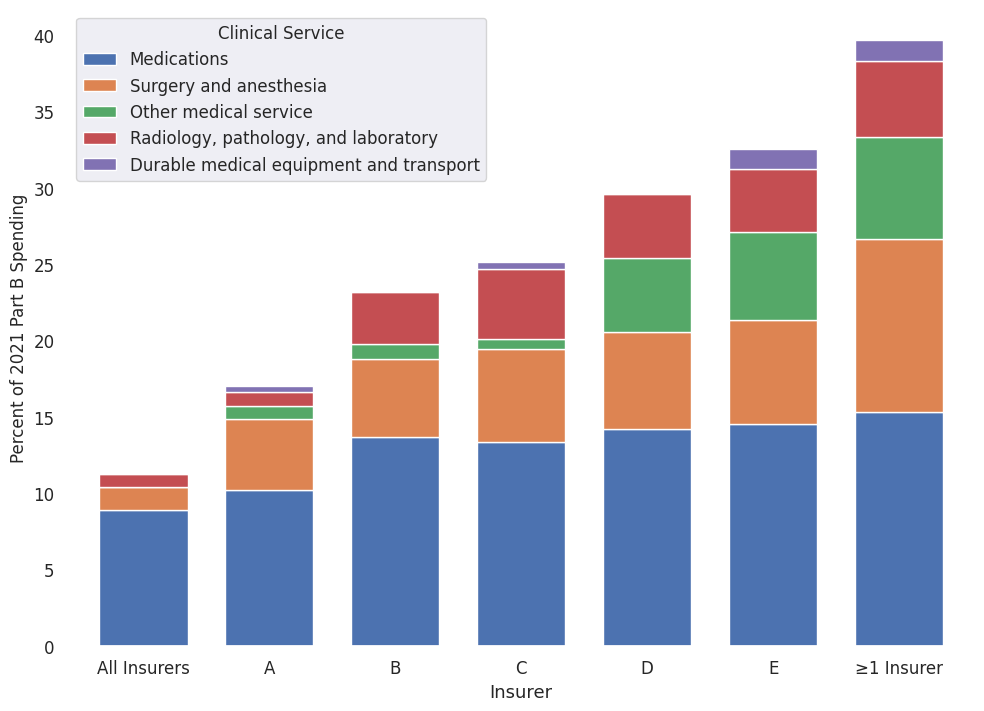

In [52]:
# Change labels
# percent_of_total_b_sorted.rename(index = {'All Insurers': 'Test'}, inplace = True)

# Sets background to white from now on
sns.set(style='white')

# Changes size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Creates the graph
ax = percent_of_total_b_sorted.plot(kind='bar', stacked=True, width=0.7)

# No gridlines
ax.grid(False)

#Formats y axis as percentages
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.tick_params(axis='both', labelsize=12)

# Y axis label
plt.ylabel('Percent of 2021 Part B Spending', fontsize=12)

# X axis label
plt.xlabel('Insurer', fontsize = 13)

#Sets title
#plt.title(' Percentage of total Part B spending on each clinical service area requiring prior auth, by insurer')

# Legend size and spot
legend = plt.legend(prop={'size': 12})

# Title of legend
legend.set_title('Clinical Service', prop={'size': 12})

# Rotates labels
plt.xticks(rotation = 0)

ax.set_facecolor('white')

In [53]:
# Defining new order
new_cols = ['Medications', 'Surgery and anesthesia', 'Other medical service', 'Radiology, pathology, and laboratory', 'Durable medical equipment and transport']

# Reorders columns based on order of new_cols
percent_of_total_b_thresholds = percent_of_total_b_thresholds[new_cols]

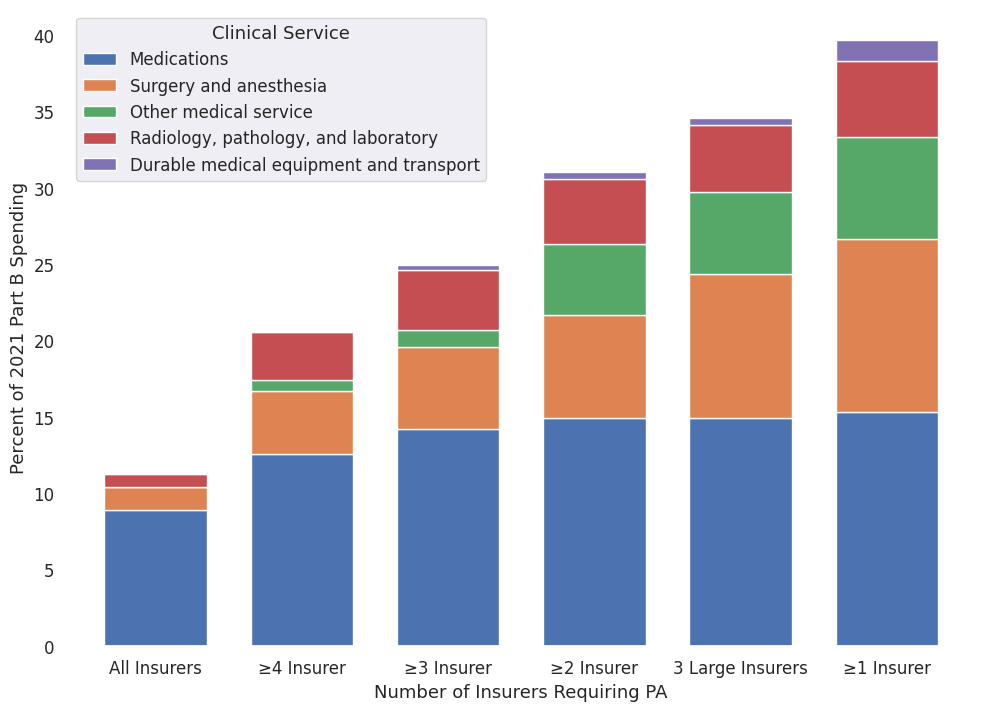

In [54]:
# CHANGE MADE
new_index = list(percent_of_total_b_thresholds.index)
#new_index.remove('3 Large Insurers')
percent_of_total_b_thresholds = percent_of_total_b_thresholds.reindex(new_index)
# CHANGE MADE

percent_of_total_b_thresholds['Total'] = percent_of_total_b_thresholds.sum(axis = 1)
percent_of_total_b_thresholds_sorted = percent_of_total_b_thresholds.sort_values(by = 'Total').drop(columns = 'Total')

percent_of_total_b_thresholds_sorted = percent_of_total_b_thresholds_sorted[new_cols]

# Sets background to white from now on
sns.set(style='white')

# Changes size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Creates the graph
ax = percent_of_total_b_thresholds_sorted.plot(kind='bar', stacked=True, width=.7)

# No gridlines
ax.grid(False)

#Formats y axis as percentages
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.tick_params(axis='both', labelsize=12)

# Y axis label
plt.ylabel('Percent of 2021 Part B Spending', fontsize = 13)

# X axis label
plt.xlabel('Number of Insurers Requiring PA', fontsize = 13)

#Sets title
#plt.title(' Percentage of total Part B spending on each clinical service area requiring prior auth, by insurer')

# Legend size and spot
legend = plt.legend(prop={'size': 12})

# Title of legend
legend.set_title('Clinical Service', prop={'size': 13})

# Rotates labels
plt.xticks(rotation = 0)

ax.set_facecolor('white')

In [55]:
# Defining new order
new_cols = ['Medications', 'Other medical service', 'Radiology, pathology, and laboratory', 'Surgery and anesthesia', 'Durable medical equipment and transport']

# Reorders columns based on order of new_cols
percent_of_total_b_ut_thresholds = percent_of_total_b_ut_thresholds[new_cols]

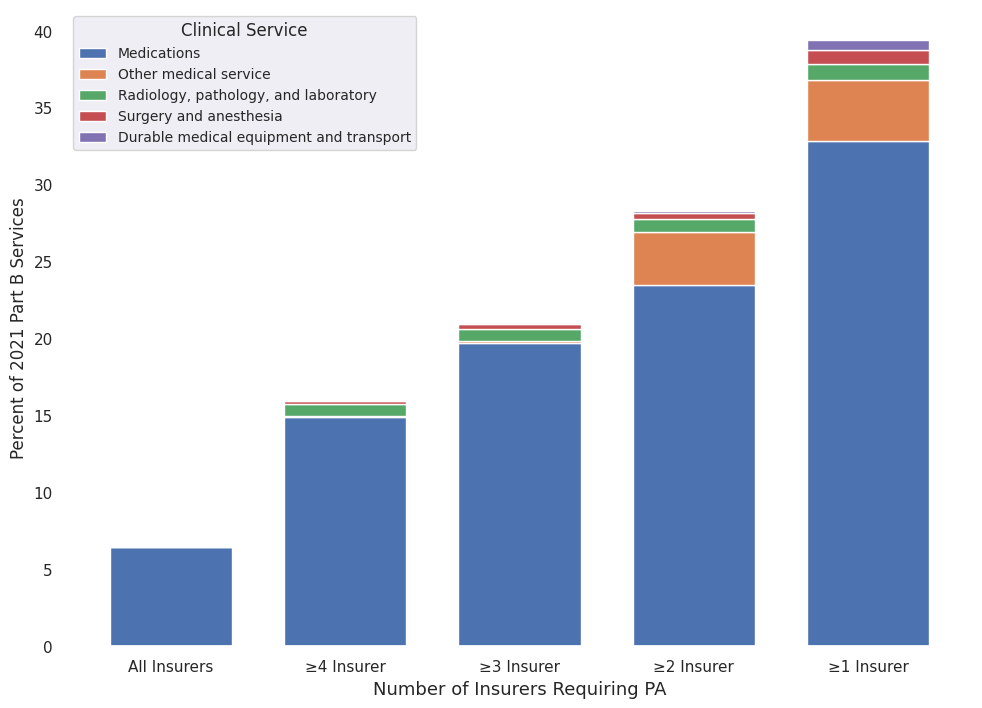

In [56]:
# CHANGE MADE
new_index = list(percent_of_total_b_ut_thresholds.index)
new_index.remove('3 Large Insurers')
percent_of_total_b_ut_thresholds = percent_of_total_b_ut_thresholds.reindex(new_index)
# CHANGE MADE

percent_of_total_b_ut_thresholds['Total'] = percent_of_total_b_ut_thresholds.sum(axis = 1)
percent_of_total_b_ut_thresholds_sorted = percent_of_total_b_ut_thresholds.sort_values(by = 'Total').drop(columns = 'Total')


percent_of_total_b_ut_thresholds_sorted = percent_of_total_b_ut_thresholds_sorted[new_cols]

# Sets background to white from now on
sns.set(style='white')

# Changes size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Creates the graph
ax = percent_of_total_b_ut_thresholds_sorted.plot(kind='bar', stacked=True, width=.7)

# No gridlines
ax.grid(False)

#Formats y axis as percentages
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Y axis label
plt.ylabel('Percent of 2021 Part B Services')

# X axis label
plt.xlabel('Number of Insurers Requiring PA', fontsize = 13)

#Sets title
#plt.title(' Percentage of total Part B spending on each clinical service area requiring prior auth, by insurer')

# Legend size and spot
legend = plt.legend(prop={'size': 10})

# Title of legend
legend.set_title('Clinical Service')

# Rotates labels
plt.xticks(rotation = 0)

ax.set_facecolor('white')

In [57]:
# Defining new order
new_cols = ['Hematology & oncology', 'Autoimmune & musculoskeletal', 'Ophthalmology', 'Other', 'Pulmonary', 'Genito-urinary & sex hormones', 'CV, diabetes, HLD', 'Neurology', 'Infectious diseases', 'Psychiatry']

# Reorders columns based on order of new_cols
percent_of_total_by_insurer_thresholds_ta = percent_of_total_by_insurer_thresholds_ta[new_cols]

In [58]:
percent_of_total_by_insurer_thresholds_ta

,Hematology & oncology,Autoimmune & musculoskeletal,Ophthalmology,Other,Pulmonary,Genito-urinary & sex hormones,"CV, diabetes, HLD",Neurology,Infectious diseases,Psychiatry
Number of Insurers Requiring PA,,,,,,,,,,
≥1 Insurer,36.920085,22.615059,17.433251,7.638157,1.699433,1.594031,1.71856,0.832959,0.152193,0.022525
≥2 Insurer,36.598527,22.288066,17.347768,7.183082,0.97506,1.567384,1.697327,0.71219,0.0,0.0
≥3 Insurer,36.050394,22.046494,17.073872,6.639074,0.093906,1.526726,0.74097,0.082309,0.0,0.0
≥4 Insurer,31.477281,20.925381,17.06923,4.931951,0.093906,0.000049,NaN,0.068208,NaN,0.0
All Insurers,25.372114,8.566422,17.06923,1.755704,NaN,0.0,NaN,0.068208,NaN,NaN
3 Large Insurers,36.599082,22.311962,17.344696,7.129801,0.97506,1.567428,1.697327,0.714202,0.0,0.0


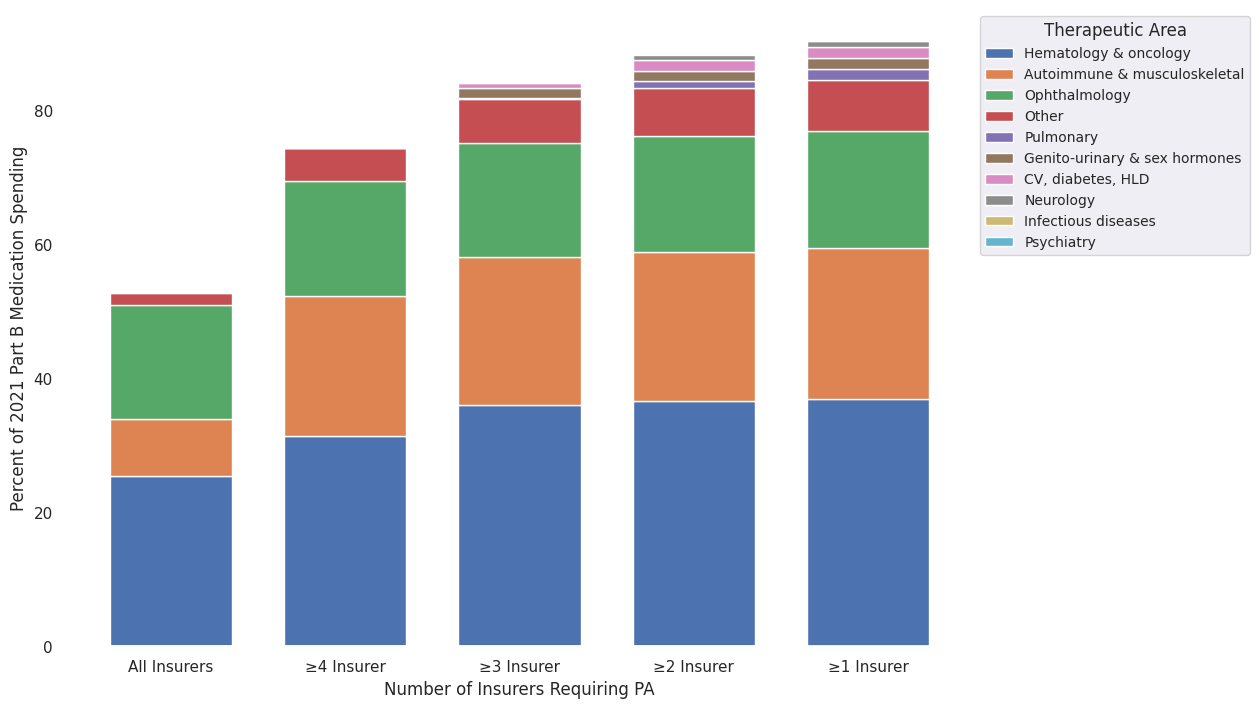

In [59]:
# CHANGE MADE
new_index = list(percent_of_total_by_insurer_thresholds_ta.index)
new_index.remove('3 Large Insurers')
percent_of_total_by_insurer_thresholds_ta = percent_of_total_by_insurer_thresholds_ta.reindex(new_index)
# CHANGE MADE

percent_of_total_by_insurer_thresholds_ta['Total'] = percent_of_total_by_insurer_thresholds_ta.sum(axis = 1)
percent_of_total_by_insurer_thresholds_ta_sorted = percent_of_total_by_insurer_thresholds_ta.sort_values(by = 'Total').drop(columns = 'Total')

# Sets background to white from now on
sns.set(style='white')

# Changes size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Creates the graph
ax = percent_of_total_by_insurer_thresholds_ta_sorted.plot(kind='bar', stacked=True, width=.7)

# No gridlines
ax.grid(False)

#Formats y axis as percentages
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Y axis label
plt.ylabel('Percent of 2021 Part B Medication Spending')

#Sets title
#plt.title(' Percentage of total Part B spending on each clinical service area requiring prior auth, by insurer')

# Legend size and spot (change location using bbox_to_anchor coordinates)
legend = plt.legend(prop={'size': 10}, bbox_to_anchor=[1, 1])

# Title of legend
legend.set_title('Therapeutic Area')

# Rotates labels
plt.xticks(rotation = 0)

ax.set_facecolor('white')

In [60]:
# Defining new order
new_cols = ['Hematology & oncology', 'Autoimmune & musculoskeletal', 'Ophthalmology', 'Other', 'Pulmonary', 'Genito-urinary & sex hormones', 'CV, diabetes, HLD', 'Neurology', 'Infectious diseases', 'Psychiatry']

# Reorders columns based on order of new_cols
percent_of_total_by_insurer_thresholds_ta_ut = percent_of_total_by_insurer_thresholds_ta_ut[new_cols]

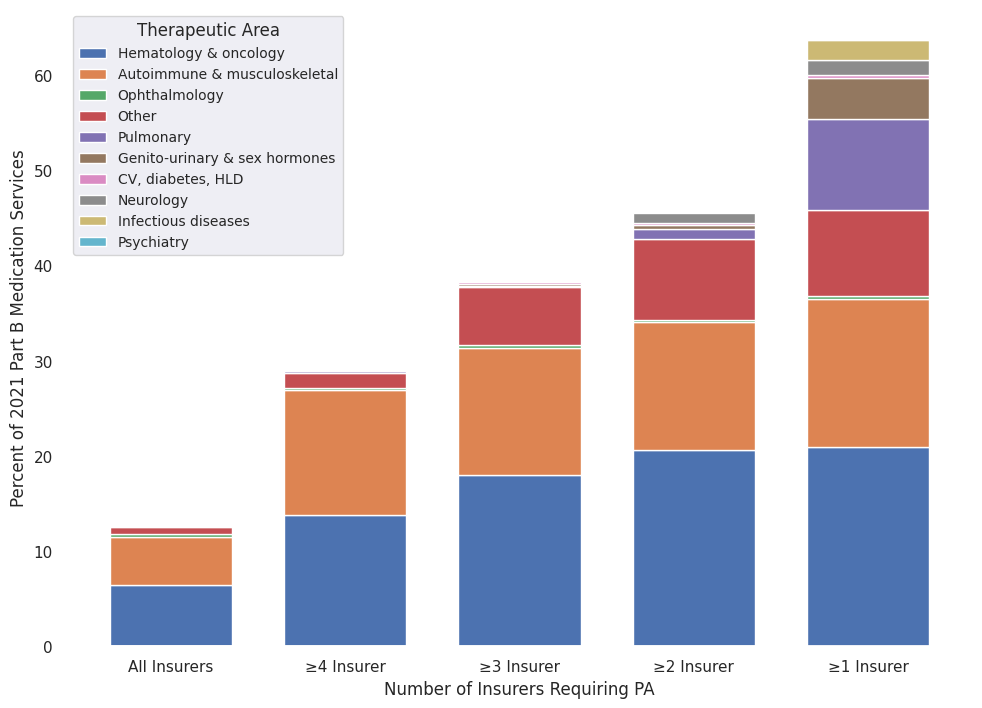

In [61]:
# CHANGE MADE
new_index = list(percent_of_total_by_insurer_thresholds_ta_ut.index)
new_index.remove('3 Large Insurers')
percent_of_total_by_insurer_thresholds_ta_ut = percent_of_total_by_insurer_thresholds_ta_ut.reindex(new_index)
# CHANGE MADE

percent_of_total_by_insurer_thresholds_ta_ut['Total'] = percent_of_total_by_insurer_thresholds_ta_ut.sum(axis = 1)
percent_of_total_by_insurer_thresholds_ta_ut_sorted = percent_of_total_by_insurer_thresholds_ta_ut.sort_values(by = 'Total').drop(columns = 'Total')

# Sets background to white from now on
sns.set(style='white')

# Changes size of the figure
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Creates the graph
ax = percent_of_total_by_insurer_thresholds_ta_ut_sorted.plot(kind='bar', stacked=True, width=.7)

# No gridlines
ax.grid(False)

#Formats y axis as percentages
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Y axis label
plt.ylabel('Percent of 2021 Part B Medication Services')

#Sets title
#plt.title(' Percentage of total Part B spending on each clinical service area requiring prior auth, by insurer')

# Legend size and spot
legend = plt.legend(prop={'size': 10})

# Title of legend
legend.set_title('Therapeutic Area')

# Rotates labels
plt.xticks(rotation = 0)

ax.set_facecolor('white')

In [62]:
# PUT REORDERING HERE
# Defining new order
new_cols = ['Medications', 'Surgery and anesthesia', 'Other medical service', 'Radiology, pathology, and laboratory', 'Durable medical equipment and transport']

In [63]:
# Reorders columns based on order of new_cols
percent_of_total_b_ut_sorted = percent_of_total_b_ut_sorted[new_cols]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'All Insurers'),
  Text(1, 0, 'A'),
  Text(2, 0, 'C'),
  Text(3, 0, 'B'),
  Text(4, 0, 'D'),
  Text(5, 0, 'E'),
  Text(6, 0, '≥1 Insurer')])

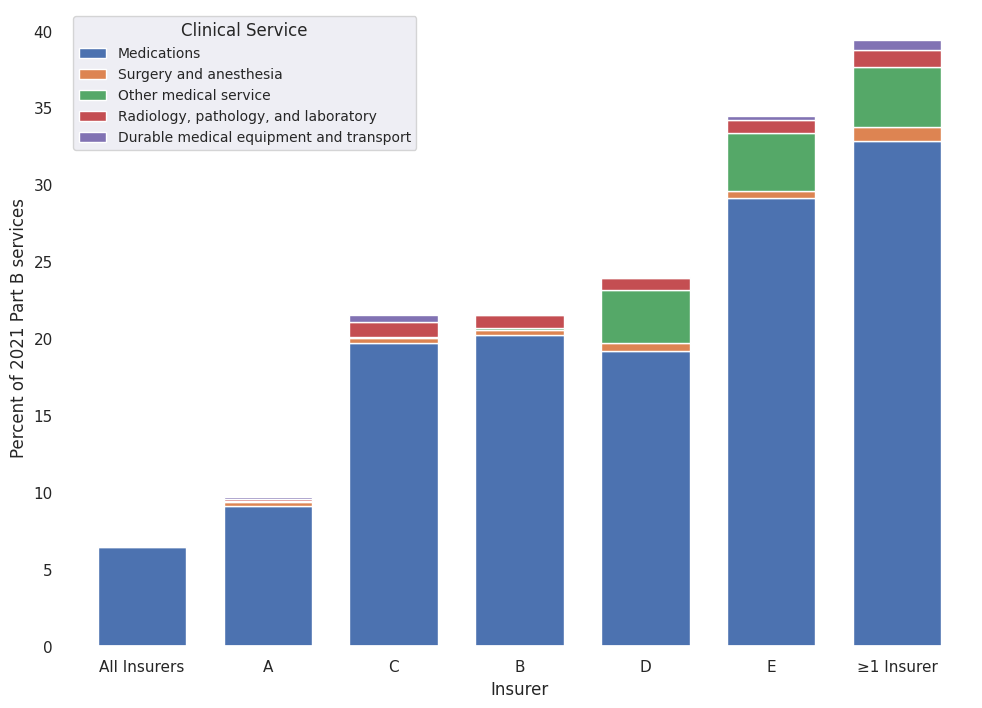

In [64]:
sns.set(style='white')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = percent_of_total_b_ut_sorted.plot(kind='bar', stacked=True, width=.7)
ax.grid(False)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
plt.ylabel('Percent of 2021 Part B services')
#plt.title(' Percentage of total Part B services on each clinical service area requiring prior auth, by insurer')
ax.grid(False)
ax.set_facecolor('white')
legend = plt.legend(prop={'size': 10})
legend.set_title('Clinical Service')
plt.xticks(rotation = 0)

In [65]:
percent_of_total_by_insurer_ta_ut

,Autoimmune & musculoskeletal,"CV, diabetes, HLD",Genito-urinary & sex hormones,Hematology & oncology,Infectious diseases,Neurology,Ophthalmology,Other,Psychiatry,Pulmonary
Insurer,,,,,,,,,,
E,15.203453,0.232697,4.043389,18.232609,2.135895,1.552967,0.269017,5.357062,0.025867,9.525684
B,13.489347,0.173515,0.420728,16.383337,0.0,0.033761,0.261479,8.342926,0.0,0.200752
D,13.361751,0.173515,0.495782,17.900995,0.0,0.996146,0.273057,3.016402,0.0,1.049075
C,13.357501,NaN,0.07921,15.934933,NaN,0.050999,0.273086,8.353732,0.0,0.200752
A,5.131261,NaN,0.0,11.43185,NaN,0.033761,0.261479,0.855244,NaN,NaN
≥1 Insurer,15.538987,0.296418,4.323027,20.979807,2.135895,1.552979,0.280514,9.124525,0.025867,9.525684
All Insurers,5.032012,NaN,0.0,6.482183,NaN,0.033761,0.261479,0.721464,NaN,NaN
3 Large \n Insurers,13.550685,0.173515,0.49789,20.608409,0.0,0.996146,0.273057,8.408436,0.0,1.049075


In [66]:
percent_of_total_by_insurer_ta[['Autoimmune & musculoskeletal', 'CV, diabetes, HLD','Genito-urinary & sex hormones', 'Hematology & oncology','Infectious diseases', 'Neurology', 'Ophthalmology', 'Psychiatry', 'Pulmonary']] = percent_of_total_by_insurer_ta[['Autoimmune & musculoskeletal', 'CV, diabetes, HLD','Genito-urinary & sex hormones', 'Hematology & oncology','Infectious diseases', 'Neurology', 'Ophthalmology', 'Psychiatry', 'Pulmonary']].apply(pd.to_numeric)
percent_of_total_by_insurer_ta['Total'] = percent_of_total_by_insurer_ta.sum(axis = 1)
percent_of_total_by_insurer_ta_new_index = list(percent_of_total_by_insurer_ta[0:5].sort_values(by = 'Total').drop(columns = 'Total').index)
percent_of_total_by_insurer_ta_sorted = percent_of_total_by_insurer_ta.reindex(['All Insurers'] + percent_of_total_by_insurer_ta_new_index + ['≥1 Insurer'])
percent_of_total_by_insurer_ta_sorted.drop(columns = 'Total', inplace = True)

In [67]:
percent_of_total_by_insurer_ta_ut[['Autoimmune & musculoskeletal', 'CV, diabetes, HLD','Genito-urinary & sex hormones', 'Hematology & oncology','Infectious diseases', 'Neurology', 'Ophthalmology', 'Psychiatry', 'Pulmonary']] = percent_of_total_by_insurer_ta_ut[['Autoimmune & musculoskeletal', 'CV, diabetes, HLD','Genito-urinary & sex hormones', 'Hematology & oncology','Infectious diseases', 'Neurology', 'Ophthalmology', 'Psychiatry', 'Pulmonary']].apply(pd.to_numeric)
percent_of_total_by_insurer_ta_ut['Total'] = percent_of_total_by_insurer_ta_ut.sum(axis = 1)
percent_of_total_by_insurer_ta_new_index_ut = list(percent_of_total_by_insurer_ta_ut[0:5].sort_values(by = 'Total').drop(columns = 'Total').index)
percent_of_total_by_insurer_ta_sorted_ut = percent_of_total_by_insurer_ta_ut.reindex(['All Insurers'] + percent_of_total_by_insurer_ta_new_index_ut + ['≥1 Insurer'])
percent_of_total_by_insurer_ta_sorted_ut.drop(columns = 'Total', inplace = True)

In [68]:
# Defining new order
new_cols = ['Hematology & oncology', 'Autoimmune & musculoskeletal', 'Ophthalmology', 'Other', 'Pulmonary', 'Genito-urinary & sex hormones', 'CV, diabetes, HLD', 'Neurology', 'Infectious diseases', 'Psychiatry']

# Reorders columns based on order of new_cols
percent_of_total_by_insurer_ta_sorted = percent_of_total_by_insurer_ta_sorted[new_cols]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'All Insurers'),
  Text(1, 0, 'A'),
  Text(2, 0, 'C'),
  Text(3, 0, 'B'),
  Text(4, 0, 'D'),
  Text(5, 0, 'E'),
  Text(6, 0, '≥1 Insurer')])

<Figure size 1170x827 with 0 Axes>

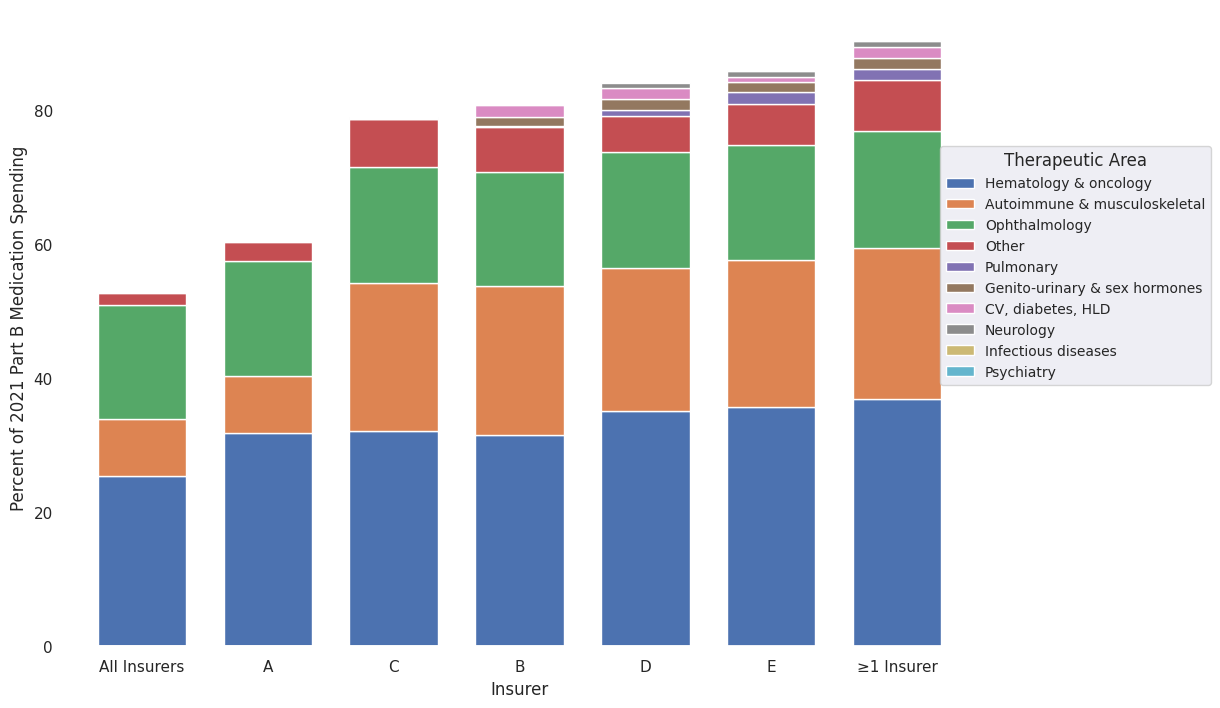

In [69]:
plt.figure()
sns.set(style='white')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = percent_of_total_by_insurer_ta_sorted.plot(kind='bar', stacked=True, width=.7)
ax.grid(False)
ax.set_facecolor('white')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
plt.ylabel('Percent of 2021 Part B Medication Spending')
#plt.title(' Percentage of total Part B medication spending on each therapeutic area requiring prior auth, by insurer')
ax.grid(False)
ax.set_facecolor('white')
legend = plt.legend(prop={'size': 10}, bbox_to_anchor=(.77, 0.4, 0.5, 0.5))
legend.set_title('Therapeutic Area')
plt.xticks(rotation = 0)

In [70]:
# PUT REORDERING HERE
# Defining new order
new_cols = ['Hematology & oncology', 'Autoimmune & musculoskeletal', 'Ophthalmology', 'Other', 'Pulmonary', 'Genito-urinary & sex hormones', 'CV, diabetes, HLD', 'Neurology', 'Infectious diseases', 'Psychiatry']

# Reorders columns based on order of new_cols
percent_of_total_by_insurer_ta_sorted_ut = percent_of_total_by_insurer_ta_sorted_ut[new_cols]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'All Insurers'),
  Text(1, 0, 'A'),
  Text(2, 0, 'D'),
  Text(3, 0, 'C'),
  Text(4, 0, 'B'),
  Text(5, 0, 'E'),
  Text(6, 0, '≥1 Insurer')])

<Figure size 1170x827 with 0 Axes>

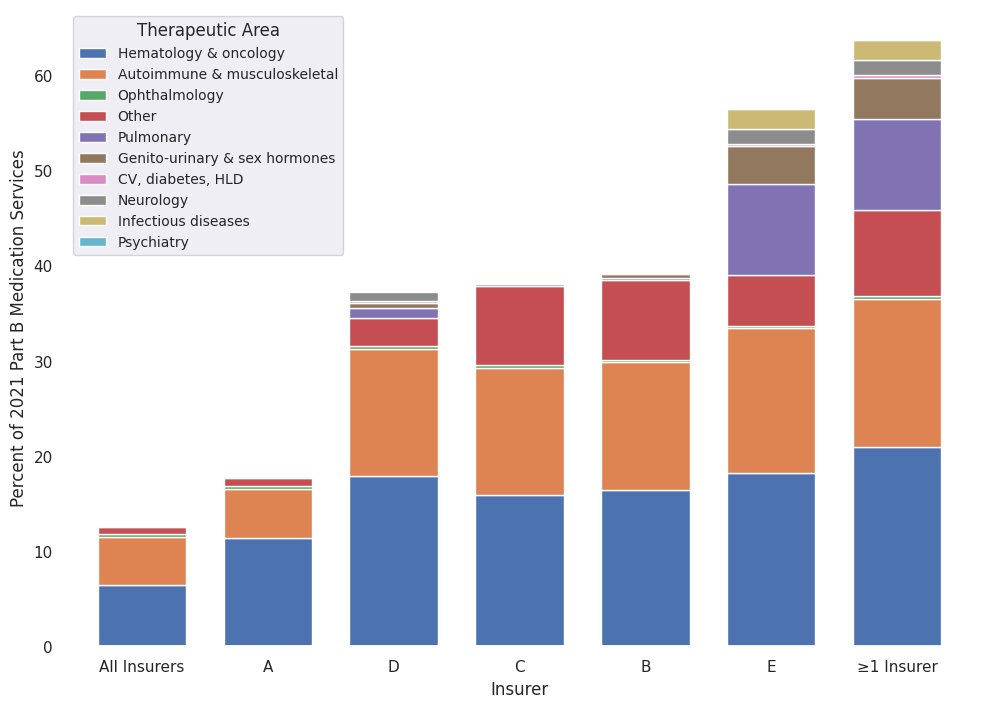

In [71]:
plt.figure()
sns.set(style='white')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = percent_of_total_by_insurer_ta_sorted_ut.plot(kind='bar', stacked=True, width=.7)
ax.grid(False)
ax.set_facecolor('white')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
plt.ylabel('Percent of 2021 Part B Medication Services')
#plt.title(' Percentage of total Part B medication services on each therapeutic area requiring prior auth, by insurer')
ax.grid(False)
ax.set_facecolor('white')
legend = plt.legend(prop={'size': 10})
legend.set_title('Therapeutic Area')
plt.xticks(rotation = 0)

### ANALYSIS FOR TABLES

### Raw Numbers (Insurer x Categories)

#### This saves the data files. Make sure to comment out the year you aren't running so it doesn't overwrite the wrong file.

In [72]:
# For 2019
total_by_insurer.transpose().to_csv('2019_spending_data_by_insurer.csv')
utilization_by_insurer.transpose().to_csv('2019_ut_data_by_insurer.csv')

total_by_insurer_ta.transpose().to_csv('2019_spending_data_by_insurer_ta.csv')
ut_by_insurer_ta.transpose().to_csv('2019_ut_data_by_insurer_ta.csv')

# ## For 2021
# total_by_insurer.transpose().to_csv('2021_spending_data_by_insurer.csv')
# utilization_by_insurer.transpose().to_csv('2021_ut_data_by_insurer.csv')

# total_by_insurer_ta.transpose().to_csv('2021_spending_data_by_insurer_ta.csv')
# ut_by_insurer_ta.transpose().to_csv('2021_ut_data_by_insurer_ta.csv')

### Total Category Counts and Sums

In [73]:

by_category_sum = spending_df.groupby('Category').sum()
by_category_count = spending_df.groupby('Category').count()

by_ta_sum = spending_df.groupby('Therapeutic_area').sum()
by_ta_count = spending_df.groupby('Therapeutic_area').count()

<ipython-input-73-8a88753326b1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_category_sum = spending_df.groupby('Category').sum()
<ipython-input-73-8a88753326b1>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_ta_sum = spending_df.groupby('Therapeutic_area').sum()


In [74]:
by_ta_sum

,HUMANA (Current),HUMANA (2020),HUMANA (2019),AETNA BINARY,Num Insurers That Require PR,At Least One Require Prior Auth,All Require Prior Auth,ndc_code,sub_category_id,multum_category_id,...,>60% Agree,>55% Agree,WELLCARE BINARY,United,Cigna,At Least Two Require Prior Auth,At Least Three Require Prior Auth,At Least Four Require Prior Auth,Num Major Insurers Require PR,Major Insurers Require PR
Therapeutic_area,,,,,,,,,,,,,,,,,,,,,
Autoimmune & musculoskeletal,54,53,49,57,253,83,13,2.543719e+12,26116.0,20546.0,...,81,81,72,20,50,66,50,41,131,68
"CV, diabetes, HLD",4,4,4,4,15,10,0,1.454124e+11,5076.0,2159.0,...,12,12,7,0,0,4,1,0,8,4
Genito-urinary & sex hormones,12,11,10,15,63,30,1,8.626473e+11,20632.0,7296.0,...,36,36,25,3,8,18,11,3,30,19
Hematology & oncology,140,133,119,108,732,230,41,4.952787e+12,38708.0,8625.0,...,218,218,213,139,132,203,146,112,387,205
Infectious diseases,3,3,3,1,34,32,0,1.234244e+12,15709.0,554.0,...,39,39,30,0,0,2,0,0,4,3
Neurology,12,13,11,2,53,38,1,8.470177e+11,14292.0,5727.0,...,39,39,35,1,3,9,3,2,15,12
Ophthalmology,10,10,9,5,42,14,5,7.456746e+11,3727.0,2499.0,...,12,12,11,5,11,11,7,5,20,10
Other,49,49,46,59,265,92,16,2.608050e+12,23071.0,17415.0,...,89,89,77,23,57,64,52,41,131,63
Psychiatry,1,1,0,1,12,9,0,4.464422e+11,3795.0,3761.0,...,10,10,9,0,1,1,1,1,2,1


In [75]:
total_by_insurer_ta

,Autoimmune & musculoskeletal,"CV, diabetes, HLD",Genito-urinary & sex hormones,Hematology & oncology,Infectious diseases,Neurology,Ophthalmology,Other,Psychiatry,Pulmonary
Insurer,,,,,,,,,,
E,5276219235.34,182474975.91,371898731.44,8554736578.25,36435759.59,198932368.89,4108761764.91,1466759927.33,5392472.66,406851878.2
B,5332597628.38,406347582.24,339243368.59,7549548688.72,0.0,16329406.84,4086450001.29,1611608826.33,0.0,22481422.98
D,5130495237.33,406347582.24,374798483.05,8404604230.48,0.0,170983226.53,4152397987.58,1269979033.61,0.0,233433683.85
C,5293607440.0,NaN,36433137.94,7705247906.79,NaN,19705194.31,4153133276.04,1699073036.86,0.0,22481422.98
A,2055588591.66,NaN,0.0,7627173014.940001,NaN,16329406.84,4086450001.29,691328930.23,NaN,NaN
≥1 Insurer,5414146297.72,411431049.85,381618193.6,8838833699.77,36435759.59,199414041.1,4173598409.06,1828609085.39,5392472.66,406851878.2
All Insurers,2050839701.18,NaN,0.0,6074197744.54,NaN,16329406.84,4086450001.29,420323458.14,NaN,NaN
3 Large \n Insurers,5341583724.82,406347582.24,375249341.04,8761984157.700001,0.0,170983226.53,4152397987.58,1706906254.85,0.0,233433683.85


In [76]:
total_by_insurer_ta.transpose()

Insurer,E,B,D,C,A,≥1 Insurer,All Insurers,3 Large \n Insurers
Autoimmune & musculoskeletal,5276219235.34,5332597628.38,5130495237.33,5293607440.0,2055588591.66,5414146297.72,2050839701.18,5341583724.82
"CV, diabetes, HLD",182474975.91,406347582.24,406347582.24,NaN,NaN,411431049.85,NaN,406347582.24
Genito-urinary & sex hormones,371898731.44,339243368.59,374798483.05,36433137.94,0.0,381618193.6,0.0,375249341.04
Hematology & oncology,8554736578.25,7549548688.72,8404604230.48,7705247906.79,7627173014.940001,8838833699.77,6074197744.54,8761984157.700001
Infectious diseases,36435759.59,0.0,0.0,NaN,NaN,36435759.59,NaN,0.0
Neurology,198932368.89,16329406.84,170983226.53,19705194.31,16329406.84,199414041.1,16329406.84,170983226.53
Ophthalmology,4108761764.91,4086450001.29,4152397987.58,4153133276.04,4086450001.29,4173598409.06,4086450001.29,4152397987.58
Other,1466759927.33,1611608826.33,1269979033.61,1699073036.86,691328930.23,1828609085.39,420323458.14,1706906254.85
Psychiatry,5392472.66,0.0,0.0,0.0,NaN,5392472.66,NaN,0.0
Pulmonary,406851878.2,22481422.98,233433683.85,22481422.98,NaN,406851878.2,NaN,233433683.85


In [77]:
spending_df.to_excel('spending_and_ut_final.xlsx')